## Do some hyper parameter tuning using cross validation

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import importlib
import climbing_ticks_helper as helper
importlib.reload(helper)
pd.set_option('display.expand_frame_repr', False) # display full data in terminal
%matplotlib inline

In [74]:
df = pd.read_csv('/app/model_ready_ticks.csv')
X = df.drop(columns=['Attempts', 'Lead Style'])
y = df[['Attempts', 'Lead Style']]


"""
Hyperparameters:
n_estimators: number of trees in the forest
max_depth: max number of levels in each decision tree
max_features: max number of features considered for splitting a node
min_samples_split: min number of data points placed in a node before the node is split
"""

n_estimators = np.linspace(10, 1000, 100, dtype=int)
max_features = [2,3,4,5,6]
max_depth = [2,3,4,5,6]
min_samples_split = [2,5,10]
criterion = ['entropy', 'gini', 'log_loss']

random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__criterion': criterion}

# Use a MultiOutputClassifer to wrap the RandomForestClassifier, so we can predict both attempts and lead style
moc = MultiOutputClassifier(RandomForestClassifier())
rf_random = RandomizedSearchCV(estimator=moc, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X, y)

print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'estimator__n_estimators': np.int64(960), 'estimator__min_samples_split': 5, 'estimator__max_features': 4, 'estimator__max_depth': 2, 'estimator__criterion': 'log_loss'}


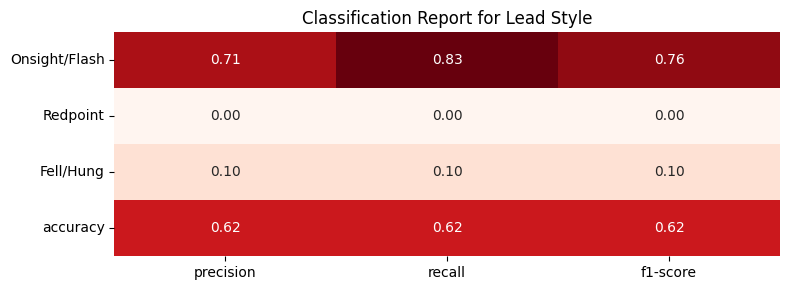

We got 57 Lead Style predictions wrong out of 213 total predictions.
We got 25 Attempts predictions wrong out of 213 total predictions.


,Route,RouteID,Date,Route Type,Alpine,Safety,Avg Stars,Pitches,Rating,Predicted Lead Style,Lead Style,Predicted Attempts,Attempts
4,Anarchy Rules,105749011,2019-05-03,Sport,0.0,G,3.0,1,5.12b,Fell/Hung,Redpoint,1,4
10,Community Service,105753379,2017-10-08,Sport,0.0,G,2.9,1,5.11c,Onsight/Flash,Redpoint,1,3
13,No Rest For the Wicked,105750037,2020-01-05,Sport,0.0,G,3.6,1,5.12a/b,Fell/Hung,Redpoint,1,4
14,Radometer in the Red Zone,105751579,2022-10-22,Sport,0.0,G,2.6,1,5.11c,Onsight/Flash,Fell/Hung,1,1
15,The View,121464048,2020-11-23,Sport,0.0,PG13,2.0,1,5.11b,Onsight/Flash,Fell/Hung,1,1
16,Living in America,105750046,2022-04-10,Sport,0.0,G,3.0,1,5.12a,Fell/Hung,Redpoint,1,2
21,Dope Shinto,105856679,2018-06-07,Sport,0.0,G,3.5,1,5.12a,Fell/Hung,Onsight/Flash,1,1
28,The Juvenile,107220802,2020-09-12,Sport,0.0,G,3.8,1,5.12a,Fell/Hung,Redpoint,1,2
30,The Pollinator,105757681,2018-07-07,Sport,0.0,G,2.3,1,5.12a,Onsight/Flash,Fell/Hung,1,1
32,Three Heavy,121641359,2019-04-19,Sport,0.0,G,0.5,1,5.11d,Onsight/Flash,Fell/Hung,1,1


In [87]:
# best values from the RandomSearchCV
n_estimators = 300
min_samples_split = 5
max_features = 5
max_depth = 2
criterion = 'gini'

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, max_features=max_features, max_depth=max_depth, criterion=criterion)
moc=MultiOutputClassifier(rf)
moc.fit(X_train, y_train)

y_pred = moc.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# make y_test a df so that the columns match. this is probably not idiomatic
helper.print_classification_report(y_test_df, y_pred_df)

df_pretty = pd.read_csv('/app/grouped_ticks.csv')
df_pretty = df_pretty[df_pretty['RouteID'].isin(X_test['RouteID'])].set_index('RouteID').loc[X_test['RouteID']].reset_index()
df_combined = helper.combine_predictions_with_data(df_pretty, y_pred_df)

# print all rows that got Lead Style wrong
wrong_preds_style = df_combined[df_combined['Lead Style'] != df_combined['Predicted Lead Style']]
wrong_preds_attempts = df_combined[df_combined['Attempts'] != df_combined['Predicted Attempts']]
print(f'We got {len(wrong_preds_style)} Lead Style predictions wrong out of {y_pred_df.shape[0]} total predictions.')
print(f'We got {len(wrong_preds_attempts)} Attempts predictions wrong out of {y_pred_df.shape[0]} total predictions.')

wrong_preds_style.head(10)

In [89]:
df_combined[df_combined['Attempts'] > 1]

,Route,RouteID,Date,Route Type,Alpine,Safety,Avg Stars,Pitches,Rating,Predicted Lead Style,Lead Style,Predicted Attempts,Attempts
4,Anarchy Rules,105749011,2019-05-03,Sport,0.0,G,3.0,1,5.12b,Fell/Hung,Redpoint,1,4
10,Community Service,105753379,2017-10-08,Sport,0.0,G,2.9,1,5.11c,Onsight/Flash,Redpoint,1,3
13,No Rest For the Wicked,105750037,2020-01-05,Sport,0.0,G,3.6,1,5.12a/b,Fell/Hung,Redpoint,1,4
16,Living in America,105750046,2022-04-10,Sport,0.0,G,3.0,1,5.12a,Fell/Hung,Redpoint,1,2
28,The Juvenile,107220802,2020-09-12,Sport,0.0,G,3.8,1,5.12a,Fell/Hung,Redpoint,1,2
37,Super Tuscan,114534087,2023-04-09,Sport,0.0,G,3.8,1,5.13b,Fell/Hung,Redpoint,1,14
38,Storm,106126227,2017-05-06,Trad,0.0,G,3.6,1,5.12b,Fell/Hung,Redpoint,1,2
49,Hey Good Lookin',105750208,2021-05-26,Sport,0.0,G,2.9,1,5.11d,Onsight/Flash,Redpoint,1,2
53,Rotten Pillar,112844621,2022-02-17,Sport,0.0,G,3.3,1,5.11d,Fell/Hung,Redpoint,1,2
56,Kor's Corner,105754465,2023-05-27,Sport,0.0,G,2.9,1,5.11d,Onsight/Flash,Redpoint,1,3


[CV] END estimator__criterion=log_loss, estimator__max_depth=2, estimator__max_features=4, estimator__min_samples_split=5, estimator__n_estimators=960; total time=   1.9s
[CV] END estimator__criterion=gini, estimator__max_depth=4, estimator__max_features=6, estimator__min_samples_split=10, estimator__n_estimators=650; total time=   1.6s
[CV] END estimator__criterion=log_loss, estimator__max_depth=6, estimator__max_features=5, estimator__min_samples_split=10, estimator__n_estimators=190; total time=   0.5s
[CV] END estimator__criterion=log_loss, estimator__max_depth=3, estimator__max_features=3, estimator__min_samples_split=2, estimator__n_estimators=510; total time=   1.1s
[CV] END estimator__criterion=entropy, estimator__max_depth=4, estimator__max_features=6, estimator__min_samples_split=10, estimator__n_estimators=270; total time=   0.5s
[CV] END estimator__criterion=entropy, estimator__max_depth=5, estimator__max_features=4, estimator__min_samples_split=10, estimator__n_estimators=